In [2]:
import sys, os
sys.path.insert(0, '/home/niell_lab/Documents/github/FreelyMovingEphys/')
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
from projects.ephys.population import Population
from src.utils.path import find
from src.utils.auxiliary import flatten_series
from scipy.interpolate import interp1d
from scipy.stats import linregress

In [3]:
from src.utils.auxiliary import flatten_series
from matplotlib.backends.backend_pdf import PdfPages

In [4]:
from tqdm import tqdm
from sklearn.neighbors import KernelDensity

In [5]:
%matplotlib inline

In [6]:
mpl.rcParams.update({'font.size': 13})
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False

# Load data

In [7]:
hffm_savepath = '/home/niell_lab/data/freely_moving_ephys/batch_files/021022/hffm'
hffm = Population(savepath=hffm_savepath)
hffm.load(fname='hffm_031822')

reading from /home/niell_lab/data/freely_moving_ephys/batch_files/021022/hffm/hffm_031822.pickle


# check dHead/dEye

In [8]:
demo = hffm.data[hffm.data['session']=='102621_J558NC_control_Rig2'].iloc[0]

In [9]:
dEye = demo['FmLt_dEye_dps']
dHead = demo['FmLt_dHead']
dGaze = demo['FmLt_dGaze']
eyeT = demo['FmLt_eyeT']

In [10]:
saccthresh = {
    'head_moved': 60,
    'gaze_moved': 240,
    'gaze_stationary': 120
}

In [12]:
other = np.arange(eyeT.size-1)
other = other[~gazeL & ~gazeR & ~compL & ~compR]

Text(0, 0.5, 'dEye (deg/sec)')

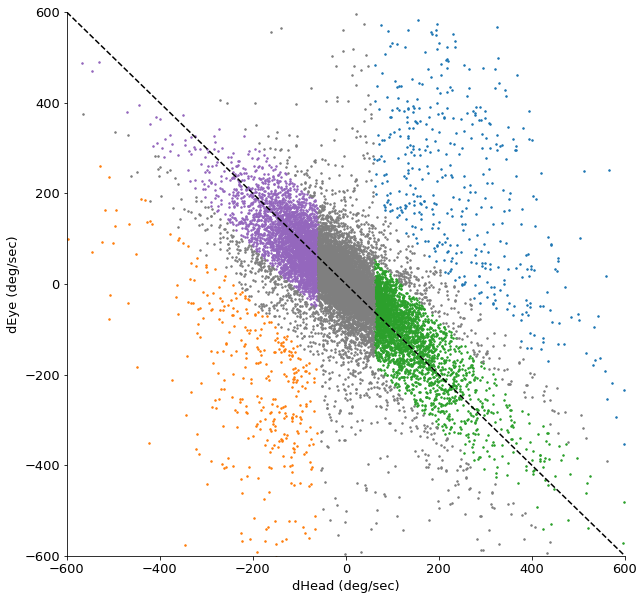

In [13]:
plt.figure(figsize=(10,10))

plt.plot(dHead[gazeL][::10], dEye[gazeL][::10], '.', color='tab:blue', markersize=3)
plt.plot(dHead[gazeR][::10], dEye[gazeR][::10], '.', color='tab:orange', markersize=3)

plt.plot(dHead[compL][::10], dEye[compL][::10], '.', color='tab:green', markersize=3)
plt.plot(dHead[compR][::10], dEye[compR][::10], '.', color='tab:purple', markersize=3)

plt.plot(dHead[other][::10], dEye[other][::10], '.', color='tab:grey', markersize=3)

plt.xlim([-600,600]); plt.ylim([-600,600])

plt.plot([-600,600],[600,-600],'k--')

plt.xlabel('dHead (deg/sec)')
plt.ylabel('dEye (deg/sec)')

# Use spike density function for eye movement signals (and change thresholds)

In [7]:
def calc_kde_sdf(spikeT, eventT, bandwidth=10, resample_size=1, edgedrop=15, win=1000):
    """
    bandwidth (in msec)
    resample_size (msec)
    edgedrop (msec to drop at the start and end of the window so eliminate artifacts of filtering)
    win = 1000msec before and after
    """
    # some conversions
    bandwidth = bandwidth/1000 # msec to sec
    resample_size = resample_size/1000 # msec to sec
    win = win/1000 # msec to sec
    edgedrop = edgedrop/1000
    edgedrop_ind = int(edgedrop/resample_size)

    # setup time bins
    bins = np.arange(-win-edgedrop, win+edgedrop+resample_size, resample_size)

    # get timestamp of spikes relative to events in eventT
    sps = []
    for i, t in enumerate(eventT):
        sp = spikeT-t
        sp = sp[(sp <= (win+edgedrop)) & (sp >= (-win-edgedrop))] # only keep spikes in this window
        sps.extend(sp)
    sps = np.array(sps) # all values in here are between -1 and 1

    # kernel density estimation
    kernel = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(sps[:,np.newaxis])
    density = kernel.score_samples(bins[:,np.newaxis])
    sdf = np.exp(density)*(np.size(sps)/np.size(eventT)) # convert back to spike rate
    sdf = sdf[edgedrop_ind:-edgedrop_ind]
    bins = bins[edgedrop_ind:-edgedrop_ind]

    return bins, sdf

In [8]:
def apply_win_to_comp_sacc(comp, gazeshift, win=0.25):
    bad_comp = np.array([c for c in comp for g in gazeshift if ((g>(c-win)) & (g<(c+win)))])
    comp_times = np.delete(comp, np.isin(comp, bad_comp))
    return comp_times

In [9]:
dHead_saccthresh = 60 # deg/sec
dGaze_saccthresh = 240 # deg/sec

In [10]:
# only use dHead at this point, don't even calculate using dEye
for s, name in enumerate(hffm.data['session'].unique()):
    print(name)
    dHead = hffm.data['FmLt_dHead'][hffm.data['session']==name].iloc[0]
    dGaze = hffm.data['FmLt_dGaze'][hffm.data['session']==name].iloc[0]
    eyeT = hffm.data['FmLt_eyeT'][hffm.data['session']==name].iloc[0]
    
    gazeL = eyeT[(np.append(dHead, 0) > dHead_saccthresh) & (np.append(dGaze, 0) > dGaze_saccthresh)]
    gazeR = eyeT[(np.append(dHead, 0) < -dHead_saccthresh) & (np.append(dGaze, 0) < -dGaze_saccthresh)]
    
    compL = eyeT[(np.append(dHead,0) > dHead_saccthresh) & (np.append(dGaze, 0) < dGaze_saccthresh)]
    compR = eyeT[(np.append(dHead,0) < -dHead_saccthresh) & (np.append(dGaze,0) > -dGaze_saccthresh)]
    
    compL = apply_win_to_comp_sacc(compL, gazeL)
    compR = apply_win_to_comp_sacc(compR, gazeR)
    
    # SDFs
    for ind in tqdm(hffm.data[hffm.data['session']==name].index.values):
        spikeT = hffm.data.loc[ind,'FmLt_spikeT']
        
        movements = [gazeL, gazeR, compL, compR]
        movkeys = ['FmLt_gazeshift_left_SDF_dHead',
                'FmLt_gazeshift_right_SDF_dHead',
                'FmLt_comp_left_SDF_dHead',
                'FmLt_comp_right_SDF_dHead']
        timekeys = ['FmLt_gazeshift_left_times_dHead',
                'FmLt_gazeshift_right_times_dHead',
                'FmLt_comp_left_times_dHead',
                'FmLt_comp_right_times_dHead']
        for x in range(4):
            movkey = movkeys[x]; timekey = timekeys[x]
            eventT = movements[x]
            
            # save the spike density function
            bins, sdf = calc_kde_sdf(spikeT, eventT)
            hffm.data.at[ind, movkey] = sdf.astype(object)
            
            # save the saccade times
            hffm.data.at[ind, timekey] = eventT.astype(object)
        
hffm.data['SDF_bins'] = bins

062921_G6HCK1ALTRN_control_Rig2


100%|███████████████████████████████████████████| 73/73 [12:28<00:00, 10.26s/it]


070921_J553RT_control_Rig2


100%|█████████████████████████████████████████| 128/128 [41:18<00:00, 19.36s/it]


101521_J559NC_control_Rig2


100%|█████████████████████████████████████████| 67/67 [1:14:31<00:00, 66.75s/it]


102621_J558NC_control_Rig2


100%|███████████████████████████████████████| 102/102 [1:06:49<00:00, 39.31s/it]


110321_J558LT_control_Rig2


100%|███████████████████████████████████████████| 35/35 [20:26<00:00, 35.04s/it]


110421_J569LT_control_Rig2


100%|███████████████████████████████████████████| 71/71 [19:58<00:00, 16.88s/it]


122021_J581RT_control_Rig2


100%|███████████████████████████████████████████| 60/60 [14:33<00:00, 14.55s/it]


020222_J577TT_control_Rig2


100%|███████████████████████████████████████████| 50/50 [11:20<00:00, 13.62s/it]


020422_J577RT_control_Rig2


100%|█████████████████████████████████████████| 130/130 [30:59<00:00, 14.30s/it]


ValueError: Length of values (2001) does not match length of index (716)

In [11]:
hffm.data['FmLt_gazeshift_left_SDF_dHead']

0      [1.6997241844992135, 1.7101800351135, 1.717222...
1      [1.1314860660147366, 1.1580571681471976, 1.181...
2      [1.1674341841296496, 1.18304237844255, 1.19671...
3      [2.021089094781126, 2.0673708219936247, 2.1116...
4      [1.1760162690479423, 1.2020520450716932, 1.225...
                             ...                        
711    [0.5447046893667081, 0.5554159647070622, 0.565...
712    [0.2881459961359472, 0.29113688538874705, 0.29...
713    [0.5263705137828768, 0.528322004667291, 0.5280...
714    [5.324288762210706, 5.393055030793001, 5.45290...
715    [7.017219527364949, 7.118512051754067, 7.20541...
Name: FmLt_gazeshift_left_SDF_dHead, Length: 716, dtype: object

In [13]:
hffm.save(fname='hffm_041122_sdf', savedir='/home/niell_lab/Desktop/')

saving to /home/niell_lab/Desktop/hffm_041122_sdf.pickle


In [18]:
np.save('/home/niell_lab/Desktop/SDF_bins.npy', bins)

# STAs saving all lags